<a href="https://colab.research.google.com/github/hany606/COEX-Internship19/blob/master/projects/Human_pose_estimation/Human_pose_estimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

######################################## **Colab environment** ########################################

---


In [22]:
# Connect with Google drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


############################################ **Installation** ############################################

---



### Installation of required libraries: Openpose and its dependency



In [0]:
import os
from os.path import exists, join, basename, splitext

git_repo_url = 'https://github.com/CMU-Perceptual-Computing-Lab/openpose.git'
project_name = splitext(basename(git_repo_url))[0]
if not exists(project_name):
  print("In process")
  # see: https://github.com/CMU-Perceptual-Computing-Lab/openpose/issues/949
  # install new CMake becaue of CUDA10
  print("################################## Install CMake ##################################")
  !wget -q https://cmake.org/files/v3.13/cmake-3.13.0-Linux-x86_64.tar.gz
  !tar xfz cmake-3.13.0-Linux-x86_64.tar.gz --strip-components=1 -C /usr/local
  # clone openpose
  print("################################## Clone openpose ##################################")
  !git clone -q --depth 1 $git_repo_url
  #!cat openpose/CMakeLists.txt
  !sed -i 's/execute_process(COMMAND git checkout master WORKING_DIRECTORY ${CMAKE_SOURCE_DIR}\/3rdparty\/caffe)/execute_process(COMMAND git checkout f019d0dfe86f49d1140961f8c7dec22130c83154 WORKING_DIRECTORY ${CMAKE_SOURCE_DIR}\/3rdparty\/caffe)/g' openpose/CMakeLists.txt
  !sed -i 's/"Build OpenPose python." OFF/"Build OpenPose python." ON/g' openpose/CMakeLists.txt
  #!cat openpose/CMakeLists.txt
  # install system dependencies
  print("################################## Install Dependencies ##################################")
  !apt-get -qq install -y libatlas-base-dev libprotobuf-dev libleveldb-dev libsnappy-dev libhdf5-serial-dev protobuf-compiler libgflags-dev libgoogle-glog-dev liblmdb-dev opencl-headers ocl-icd-opencl-dev libviennacl-dev
  # build openpose
  print("################################## Build openpose ##################################")
  !cd openpose && rm -rf build || true && mkdir build && cd build && cmake .. && make -j`nproc`
  print("################################## Finished Finished ##################################")
  

######################################## **Environment Setup** #######################################

---



Go to the directory of Python API where you can use it only there

In [0]:
!pwd
!ls
import os
os.chdir('/content/openpose/build/examples/tutorial_api_python')
!pwd

############################################ **Testing** ############################################

---



To enusre that the python API has been installed correctly, the result of the below cell should have one of the files: pyopenpose.cpython-36m-x86_64-linux-gnu.so

In [0]:
!ls ../../python/openpose
#pyopenpose.cpython-36m-x86_64-linux-gnu.so

Run an example:

In [0]:
!python3 01_body_from_image.py	

Modified version from the example to work with colab to show the images as colab doesn't have a x server to show the images as in normal OS.

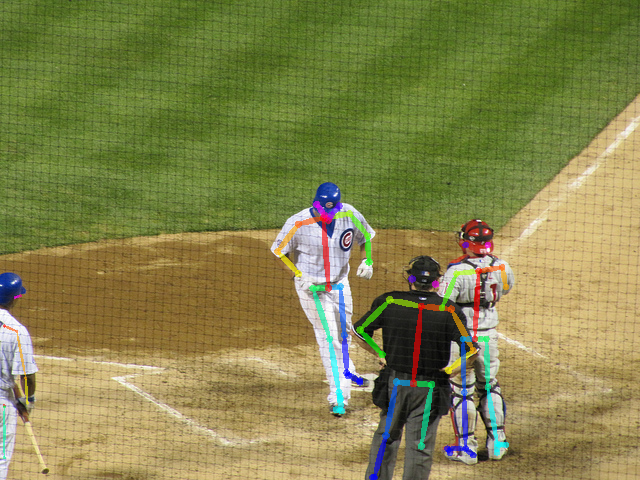

In [20]:
# From Python
# It requires OpenCV installed for Python
import sys
import cv2
import os
from sys import platform
import argparse
from google.colab.patches import cv2_imshow

# Import Openpose (Windows/Ubuntu/OSX)
dir_path = "/content/openpose/build/examples/tutorial_api_python"
try:
    # Windows Import
    if platform == "win32":
        # Change these variables to point to the correct folder (Release/x64 etc.) 
        sys.path.append(dir_path + '/../../python/openpose/Release');
        os.environ['PATH']  = os.environ['PATH'] + ';' + dir_path + '/../../x64/Release;' +  dir_path + '/../../bin;'
        import pyopenpose as op
    else:
        # Change these variables to point to the correct folder (Release/x64 etc.) 
        sys.path.append('../../python');
        # If you run `make install` (default path is `/usr/local/python` for Ubuntu), you can also access the OpenPose/python module from there. This will install OpenPose and the python library at your desired installation path. Ensure that this is in your python path in order to use it.
        # sys.path.append('/usr/local/python')
        from openpose import pyopenpose as op
except ImportError as e:
    print('Error: OpenPose library could not be found. Did you enable `BUILD_PYTHON` in CMake and have this Python script in the right folder?')
    raise e

# Flags
parser = argparse.ArgumentParser()
parser.add_argument("--image_path", default="../../../examples/media/COCO_val2014_000000000192.jpg", help="Process an image. Read all standard formats (jpg, png, bmp, etc.).")
args = parser.parse_known_args()

# Custom Params (refer to include/openpose/flags.hpp for more parameters)
params = dict()
params["model_folder"] = "../../../models/"

# Add others in path?
for i in range(0, len(args[1])):
    curr_item = args[1][i]
    if i != len(args[1])-1: next_item = args[1][i+1]
    else: next_item = "1"
    if "--" in curr_item and "--" in next_item:
        key = curr_item.replace('-','')
        if key not in params:  params[key] = "1"
    elif "--" in curr_item and "--" not in next_item:
        key = curr_item.replace('-','')
        if key not in params: params[key] = next_item

# Construct it from system arguments
# op.init_argv(args[1])
# oppython = op.OpenposePython()

try:
    # Starting OpenPose
    opWrapper = op.WrapperPython()
    opWrapper.configure(params)
    opWrapper.start()

    # Process Image
    datum = op.Datum()
    imageToProcess = cv2.imread(args[0].image_path)
    datum.cvInputData = imageToProcess
    opWrapper.emplaceAndPop([datum])

    # Display Image
#     print("Body keypoints: \n" + str(datum.poseKeypoints))
    cv2_imshow(datum.cvOutputData)
#     cv2.waitKey(0)
except Exception as e:
    # print(e)
    sys.exit(-1)


########################################## **Testing playground** ##########################################

---



######################################### **Openpose module** #########################################

---


########################################## **Camera module** ##########################################

---



##################################### **Video Stream with Openpose** #####################################

---



############################################ **Main code** ############################################

---



############################################ **Running area** ############################################

---

